<img src="./images/vit.gif" width="500px"></img>

# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* vit-pytorch - https://github.com/lucidrains/vit-pytorch/tree/main
* 原文件是用 Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention
* 原文件 - https://github.com/lucidrains/vit-pytorch/blob/main/examples/cats_and_dogs.ipynb
* 本文修改为原生的 VIT - https://github.com/lucidrains/vit-pytorch?tab=readme-ov-file#usage
* 实验的原数据:
  * Train Data: 25000
  * Test Data: 12500
  
  抽取部分做代码调试：
  * Train Data: 2000
  * Test Data: 800
* 位置编码
  * 本文的代码做的是没有位置编码的实验，论文中也有这个实验，我晕了，看白天，我就想怎么位置编码是正态分布的随机数
* python环境
  * torch 1.13.0

## 阅读的博文
 - [VIT探索笔记 （AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://blog.csdn.net/u010006102/article/details/135774692?spm=1001.2014.3001.5502)
   - 我自己写的理解博文
 - VIT代码解析 - https://zhuanlan.zhihu.com/p/361686988
 - ViT（Vision Transformer）解析 - https://zhuanlan.zhihu.com/p/445122996

## Import Libraries

In [27]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import sys


In [28]:
print("Python版本信息:")
print(sys.version)

print("torch版本信息:")
print(torch.__version__)

print("python路径:")
print(sys.executable)

Python版本信息:
3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
torch版本信息:
1.13.1+cu117
python路径:
/opt/anaconda3/envs/sd-webui/bin/python


VIT的复现 - https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

In [29]:
# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [30]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'

In [31]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## Load Data

In [32]:
os.makedirs('dataset', exist_ok=True)

In [33]:
train_dir = 'dataset/dogsVScats/train'
test_dir = 'dataset/dogsVScats/test'

In [34]:
# with zipfile.ZipFile('train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('test.zip') as test_zip:
#     test_zip.extractall('data')

In [35]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [36]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 2000
Test Data: 800


In [37]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

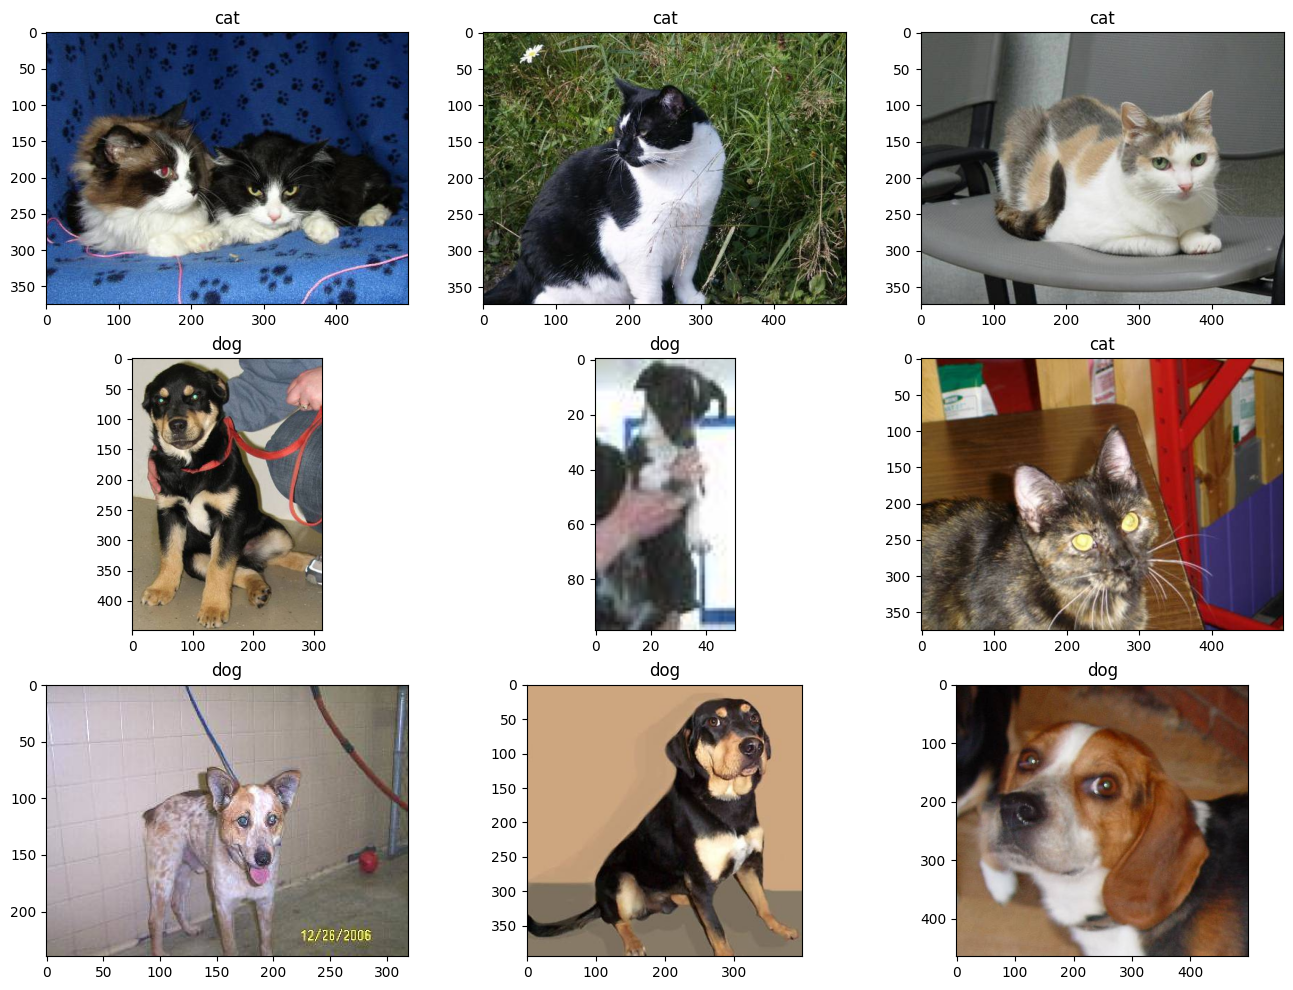

In [38]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [39]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [40]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 1600
Validation Data: 400
Test Data: 800


## Image Augmentation

In [41]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [42]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [43]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [44]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [45]:
print(len(train_data), len(train_loader))

1600 25


In [46]:
print(len(valid_data), len(valid_loader))

400 7


### Visual Transformer

In [47]:
model =  ViT(
        image_size = 224,
        patch_size = 16,
        num_classes = 2,
        dim = 128,
        depth = 6,
        heads = 16,
        mlp_dim = 128,
        dropout = 0.1,
        emb_dropout = 0.1
    ).to(device)

### Training

In [48]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [49]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7270 - acc: 0.4938 - val_loss : 0.7017 - val_acc: 0.5268



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7055 - acc: 0.5125 - val_loss : 0.6837 - val_acc: 0.5536



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6942 - acc: 0.5319 - val_loss : 0.6919 - val_acc: 0.5379



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6962 - acc: 0.5062 - val_loss : 0.6857 - val_acc: 0.5781



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6900 - acc: 0.5419 - val_loss : 0.6869 - val_acc: 0.5603



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6882 - acc: 0.5581 - val_loss : 0.6817 - val_acc: 0.5781



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6898 - acc: 0.5550 - val_loss : 0.6651 - val_acc: 0.6161



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6856 - acc: 0.5550 - val_loss : 0.6870 - val_acc: 0.5469



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6854 - acc: 0.5638 - val_loss : 0.6825 - val_acc: 0.5491



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6812 - acc: 0.5481 - val_loss : 0.6826 - val_acc: 0.5312



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6731 - acc: 0.5856 - val_loss : 0.6652 - val_acc: 0.5960



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6792 - acc: 0.5706 - val_loss : 0.6679 - val_acc: 0.5737



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6779 - acc: 0.5844 - val_loss : 0.6665 - val_acc: 0.5737



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6667 - acc: 0.5881 - val_loss : 0.6722 - val_acc: 0.5759



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6657 - acc: 0.5844 - val_loss : 0.6954 - val_acc: 0.5179



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6631 - acc: 0.5906 - val_loss : 0.6625 - val_acc: 0.6138



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6704 - acc: 0.5819 - val_loss : 0.6706 - val_acc: 0.5938



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6576 - acc: 0.6062 - val_loss : 0.6788 - val_acc: 0.5580



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6569 - acc: 0.6100 - val_loss : 0.6647 - val_acc: 0.5893



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6505 - acc: 0.6212 - val_loss : 0.6667 - val_acc: 0.5670

